# Proyecto ciencia de datos

En el siguiente trabajo se presentará un estudio detallado de un proyecto de ciencia de datos sobre un conjunto de datos real. El objetivo es el de obtener un modelo con la mayor capacidad predictiva realizando previamente un análisis de los datos.

## Autores

* Joaquín Borrego Villa
* Marco A. Montes Grova

## Librerías y funciones 

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder, normalize, StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay, RocCurveDisplay
from sklearn import svm

## 1. Exploración y visualización mediante gráficos.

El dataset con el que se va realizar el estudio se conoce como *Bank Marketing* y ha sido obtenido del banco de datos spreedsheats y esta disponible aquí: [Bank Marketing](https://www.apispreadsheets.com/datasets/135). El dataset está relacionado con campañas de marketing llevadas a cabo mediante llamadas de teléfono por un banco portugués. El objetivo es clasificar si el cliente se suscribirá o no al servicio del cliente dependiendo de sus antecedentes. 

Se va a cargar el dataset con la librería *Pandas*, que es una librería que permite el manejo y análisis de estructuras de datos. Se llevará a cabo un estudio del conjunto de datos para conocer su magnitud, forma y analizar los atributos y la variable de clasificación.

In [194]:
# Conjunto de datos Bank Marketing
df = pd.read_csv("bank_marketing_dataset.csv", delimiter=",")
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199.0,4,-1.0,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226.0,1,-1.0,0,unknown,no


In [4]:
# Información acerca de los atributos
attributes_df = pd.read_csv("attributes_bank_marketing.csv", delimiter=",")
attributes_df.head(attributes_df.shape[0])

,name,type,description
0,age,integer,Age of client: numerical value
1,job,string,"Type of job: admin., blue-collar, entrepreneur..."
2,marital,string,"Marital status: divorced, married, single, unk..."
3,education,string,"Level of education: primary, secondary, tertia..."
4,default,string,"Has credit in default: no, yes, unknown"
5,balance,integer,Average yearly balance in Euro: numerical value
6,housing,string,"Has housing loan: no, yes, unknown"
7,loan,string,"Has personal loan: no, yes, unknown"
8,contact,string,"Communication type: unknown, telephone, cellular"
9,day,integer,Day of the month: numerical value between 1 an...


In [5]:
print("El conjunto de datos tiene {} filas y {} columnas".format(df.shape[0], df.shape[1]))

x_data = df.iloc[:,0:-1]
y_data = df.iloc[:, -1]

X_names = df.columns.to_list()[:-1]
y_names = df.columns.to_list()[-1]

print("El tamaño de atributos del conjunto de datos es {} y sus nombres son {}".format(len(X_names),X_names))

El conjunto de datos tiene 4521 filas y 17 columnas
El tamaño de atributos del conjunto de datos es 16 y sus nombres son ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


Se ha cargado el conjunto de datos y se ha obtenido gracias al *DataFrame* de *Pandas* que está compuesto por 4521 entradas, cada una de ellas compuesta por 16 posibles atributos y una clase. 

Además, se ha cargado el tipo de dato y la descripción de cada uno de esos atributos y se puede observar que existen tanto variables categóricas (*string*), como variables numéricas (*float, integer*). Ya que estamos en un problema de clasificación, los posibles valores  de la variable respuesta (clases) están definidos, en este caso puede ser que el cliente si compre el servicio del banco (clase: "yes") o que no lo compre (clase: "no").

En el conjunto de datos se puede observar que hay valores de los atributos que son desconocidos ("unknown"), estos valores se van a considerar como *valores ausentes* (en primera instancia, como trabajo acádemico ya que en realidad no son valores ausentes ya que se conoce su valor) y tienen que ser tratados ya que dependiendo de como los consideremos obtendremos diferentes resutados, por lo que vamos a calcular cuantos de esos valores existen en nuestro conjunto de datos. 

In [6]:
valores_ausentes = np.sum(x_data[X_names] == "unknown") + np.sum(x_data[X_names] == -1.0)
total_valores_ausentes = np.sum(valores_ausentes)
total_valores = df.shape[0] * df.shape[1]

print("Los valores ausentes por clase son :\n",valores_ausentes)
print("Total de valores ausentes {}/{} :{}%".format(total_valores_ausentes, total_valores, total_valores_ausentes/total_valores * 100))

# Comprobamos que las columnas en las que el número de dias es desconocido (unknown) es la misma que no tenemos valor de beneficio(-1)
array = (x_data["pdays"] == "unknown") == (x_data["poutcome"] == -1.0)
array.sum()

Los valores ausentes por clase son :
 age             0
job            38
marital         0
education     187
default         0
balance         5
housing         0
loan            0
contact      1324
day             0
month           0
duration        0
campaign        0
pdays        3705
previous        0
poutcome     3705
dtype: int64
Total de valores ausentes 8964/76857 :11.66321870486748%


4521

Si observamos el número de valores ausentes, la mayoría se encuentran tanto en el atributo *pdays* como en el atributo *poutcome*, estos atributos indican el número de días que ha pasado que otro banco contactó al cliente ofreciéndole el servicio  y si fue fructifera la anterior llamada que ofrecía dicha servicio. Esta información es díficil de obtener en una llamada telefónica o el usuario no se suele acordar por lo que la mayoría de entradas de este conjunto de datos no disponen de dicha información, de hecho se pueden comprobar que ambos atributos están relacionados ya que las entradas en las que *pdays* es desconocido ('unknown') el valor de *poutcome* es también desconocido ('-1'). 

Esto nos hace ver que quizás estos atributos en una primera iteración no nos den demasiada información al modelo, sin embargo se puede plantear realizar un estudio utilizando solo estas entradas para cuando dispongamos de esta información en una nueva entrada.

Los atributos que tienen atributos ausentes son:

* *job* : string
* *education* : string
* *contact* : string
* *pdays* : integer
* *poutcome* : string

Además de eliminar las instancias que contienen datos ausentes se pueden llevar a cabo algunas técnicas para tratar los valores ausentes como:

* Rellenar huecos vacíos usando:
    * La moda
    * La mediana
    * La media
    * Imputación predictiva

## 2. Limpieza y preprocesado de los datos.

### Sustitucion de valores ausentes por moda

Para manejar los valores ausentes se va a llevar a cabo una sustitución de estos valores por los valores que más aperezcan en cada uno de los atributos (moda).

In [209]:
columnas_ausentes = ["job", "education", "contact", "poutcome"]

def trend_sustitution(df):
    X_names = df.columns.to_list()[:-1]
    dict = {}
    for name in X_names:
        count = Counter(df[name])
        dict[name] = count.most_common(2)

    x_trend = df.copy()
    for name in columnas_ausentes:
        trend = dict[name][0][0]
        if(trend == "unknown"):
            trend = dict[name][1][0]
        x_trend[name] =x_trend[name].replace("unknown", trend)
    
    return x_trend

x_trend = trend_sustitution(df)
print("Valores ausentes en el nuevo conjunto de datos \n{}".format(np.sum(x_trend[X_names] == "unknown")))

Valores ausentes en el nuevo conjunto de datos 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


In [7]:
x_trend.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,failure,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,cellular,3,jun,199.0,4,-1.0,0,failure,no
4,59,blue-collar,married,secondary,no,0,yes,no,cellular,5,may,226.0,1,-1.0,0,failure,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141.0,2,176.0,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341.0,1,330.0,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151.0,2,-1.0,0,failure,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,cellular,14,may,57.0,2,-1.0,0,failure,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313.0,1,147.0,2,failure,no


### Eliminación de listas o de casos

Otro enfoque que se puede utilizar para tratar los datos que faltan es el de omitir estos casos y analizar los datos restantes. Este enfoque se conoce como análisis de casos completos o eliminación por lista, esta manera de tratar los datos, si se cumple el supuesto de valores MCAR ('Missing completley at Random'), es decir que el hecho de que el valor se haya perdido es totalmente aleatorio y que no depende de las medidas tomadas, produce estimaciones no sesgadas y resultados conservadores.

Procederemos a eliminar todas las entradas que contengan algún valor ausente.

In [9]:

def eliminate_mcar(df):
    df_mcar = df.copy()
    names = df_mcar.keys()
    # Obtenemos la tabla de booleanos que contiene la información de los valores unknown
    boolean_table = df_mcar[names] == "unknown"
    # calculamos por fila cual de las entradas de la entrada contiene algún unknown
    row_boolean_vector = boolean_table.any(axis = 1)
    # eliminamos los indices de el dataframe que contengan algun unknown
    df_rem = df_mcar.drop(np.where(row_boolean_vector)[0])

    return df_rem

df_mcar = eliminate_mcar(df)

print("Numero de entradas x_mcar: {}, numero de entradas iniciales {} ".format(df_mcar.shape[0], x_data.shape[0]))

Numero de entradas x_mcar: 764, numero de entradas iniciales 4521 


Definimos el método sustitution para poder realizar un estudio mas avanzado después.

In [221]:
def sustitution(df, tipo):
    if(tipo == "eliminate"):
        return eliminate_mcar(df)
    elif(tipo == "trend_sustitution"):
        return trend_sustitution(df)
    else:
        raise "Error"

Como se observa el volumen de datos del dataset filtrado es mucho más reducido, esto en algunos casos podrá conllevar problemas de heterogenia en los datos, por eso hay que tener cuidado con esta manera de tratar los datos ausentes.

### Transformación de variables categóricas a numéricas

Para poder llegar a tratar nuestro conjunto de datos para modelos de predicción, se deben transformar las variables categóricas a numéricas. Estas variables categóricas se dividen en dos tipos:

* Variables ordinales: sus valores pueden ser ordenados jerárquicamente. En este caso el atributo *education* y *poutcome* son variables ordinales.
* Variables nominales: no se pueden establecer un orden en sus categorías. En este caso todos los demás atributos categóricos.

Empezaremos a codificar las variables ordinales, para ello lo que se hará será remplazar cada valor de la variable con un número entero distinto de manera jerárquica. Es decir daremos más importancia a los distintos niveles ordinales. En nuestro atributo "education" daremos más valor al nivel "tertiary" que "primary" por lo que se le asignará un 0 a "primary", un 1 a "secondary y un 2 a "tertiary". Para el atributo "poutcome" daremos más valor a que la llamada anterior haya sido "success" que a que la llamada anterior haya sido "failure". Por lo que se asignará un 0 a "failure" un 1 a "other" y un 2 a "success". Para conocer cuales son los distintos valores de un atributo utilizamos el método "value_counts". 

Para llevar a cabo este tipo de codificación utilizaremos la clase "OrdinalEncoder" de sklearn.

In [10]:
print(df_mcar["education"].value_counts())
print(df_mcar["poutcome"].value_counts())

secondary    407
tertiary     260
primary       97
Name: education, dtype: int64
failure    466
other      183
success    115
Name: poutcome, dtype: int64


In [220]:
# Creamos el codificador indicandole el orden de la variables
ordinal_order = {"education":["primary", "secondary", "tertiary"], "poutcome":["failure", "other", "success"]}


def ordinal_encoding(df):
    df_cod = df.copy()
    for column_name in ordinal_order:
        encoder = OrdinalEncoder(categories= [ordinal_order[column_name]])
        # Ajustamos el codificador con la variable education y la transformamos
        encoder.fit(df_cod[[column_name]])
        df_cod[column_name] = encoder.transform(df_cod[[column_name]])
    
    return df_cod

df_cod = ordinal_encoding(df_mcar)
print(df_cod.head(5))


   age            job  marital  education default  balance housing loan  \
1   33       services  married        1.0      no     4789     yes  yes   
2   35     management   single        2.0      no     1350     yes   no   
5   35     management   single        2.0      no      747      no   no   
6   36  self-employed  married        2.0      no      307     yes   no   
9   43       services  married        0.0      no      -88     yes  yes   

    contact  day month  duration  campaign  pdays  previous  poutcome   y  
1  cellular   11   may     220.0         1  339.0         4       0.0  no  
2  cellular   16   apr     185.0         1  330.0         1       0.0  no  
5  cellular   23   feb     141.0         2  176.0         3       0.0  no  
6  cellular   14   may     341.0         1  330.0         2       1.0  no  
9  cellular   17   apr     313.0         1  147.0         2       0.0  no  


Para las variables categóricas que no tengan un orden jerárquico en sus categorías una mejor solución es la llamada codificación one-hot. Esta técnica consiteste en crear una nueva variable binaria por cada categoría existente en la variable a codificar. Así estas variables contendrán un 1 en aquellas observaciones que pertenezcan a esa categoría y 0 en el resto.

Para llevar a cabo este proceso utilizaremos la función "get_dummies" de pandas que se encarga de crear las variables binarias. Además activaremos el parámetro drop_first que lo que hace es generar k-1 variables binarias en vez de k siendo k el número de categorías en el atributo, ya que estaríamos añadiendo una variable extra que sería combinación lineal de las otras ya que se entienden que si todas las categorías contienen un 0, la categoría correspondiente es la de la variable eliminada.

In [11]:
def one_hot_encoding(df):
    df_cod = df.copy()

    for column_name in df.keys():
        if(df_cod[column_name].dtypes == object):
            new_columns = pd.get_dummies(df_cod[column_name], drop_first= True)
            new_columns.columns = column_name + "-" + new_columns.columns 
            df_cod = pd.concat([df_cod, new_columns], axis = 1)
            df_cod = df_cod.drop(columns= [column_name])
    
    return df_cod
    
df_one_hot = one_hot_encoding(df_cod)
df_one_hot.head(5)
# df_one_hot

,age,education,balance,day,duration,campaign,pdays,previous,poutcome,job-blue-collar,...,month-feb,month-jan,month-jul,month-jun,month-mar,month-may,month-nov,month-oct,month-sep,y-yes
1,33,1.0,4789,11,220.0,1,339.0,4,0.0,0,...,0,0,0,0,0,1,0,0,0,0
2,35,2.0,1350,16,185.0,1,330.0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
5,35,2.0,747,23,141.0,2,176.0,3,0.0,0,...,1,0,0,0,0,0,0,0,0,0
6,36,2.0,307,14,341.0,1,330.0,2,1.0,0,...,0,0,0,0,0,1,0,0,0,0
9,43,0.0,-88,17,313.0,1,147.0,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0


Es importante tener en cuenta que como tenemos categorías que se llaman igual en atributos diferentes, es decir, "yes" y "no" aparecen en varios atributos, los nuevos atributos que produce la codificación one hot tienen que llamarse diferente. Por lo que se ha puesto el nombre del atributo originario precidiendo al nuevo. Como se observa se han transformado las 17 columnas iniciales (16 atributos + clasificación) a 37 columnas (36 atributos + clasificación)

Otra forma de codificación nominal es la de codificación por frecuencia, que consiste en contar el número de veces que aparece cada una de los valores dentro de un atributo y lo utilizaremos como codificación numérica

In [222]:
def frequency_encoding(df):
    df_cod = df.copy()
    for column_name in df.keys():
        if(df_cod[column_name].dtypes == object):
            counter = Counter(df_cod[column_name])
            df_cod[column_name] = df_cod[column_name].replace(dict(counter), value = None)

    return df_cod
            
df_freq = frequency_encoding(df_cod)
df_freq.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,33,58,456,1.0,759,4789,489,92,697,11,253,220.0,1,339.0,4,0.0,593
2,35,177,228,2.0,759,1350,489,672,697,16,111,185.0,1,330.0,1,0.0,593
5,35,177,228,2.0,759,747,275,672,697,23,73,141.0,2,176.0,3,0.0,593
6,36,26,456,2.0,759,307,489,672,697,14,253,341.0,1,330.0,2,1.0,593
9,43,58,456,0.0,759,-88,489,92,697,17,111,313.0,1,147.0,2,0.0,593


Para ello utilizamos la clase "Counter" de la librería collections que nos permite calcular cuantos valores hay de cada una de las diferentes categorías de los atributos y utilizamos estos datos para llevar a cabo la codificación

Definimos el método encoding para poder realizar un estudio mas avanzado después.

In [216]:
def encoding(df, type):
    if(type == "one_hot"):
        df = ordinal_encoding(df)
        return one_hot_encoding(df)
    elif (type == "frequency"):
        df = ordinal_encoding(df)
        return frequency_encoding(df)
    else:
        raise "Error"

# 3. Métodos de selección de características

Para reducir la dimensionalidad de el conjunto de datos se utilizan los métodos de selección de características. Para ello existen diferentes métodos:

* Métodos de filtro: Forma parte del preprocesamiento de datos, la selección de característica es independiente de cualquier algoritmo de aprendizaje automático. Cada una de las características se clasifican según unos puntajes estadísticos que derminan la correlación con la varialbe respuesta. En este contexto existen algunos métodos como:
    * Correlación de pearson
    * LDA
    * ANOVA
    * Chi cuadrado
* Métodos de envoltura: Utiliza un algoritmo de machine learning y utiliza su rendimiento como criterio de evaluación para la selección del subconjunto de características. 


## Correlación de Pearson

Se usa como medida para cuantificar la dependencia lineal entre dos variables continuas, su valor varía entre -1 a 1. Se obtendrá una métrica de la correlación entre atributos dos a dos por lo que se podrá utilizar los mapas de calor par observar cuales se pueden eliminar. Se puede observar que la variable "month" tiene unos valores de correlación altos por lo que se podría eliminar

<AxesSubplot:title={'center':'Correlación de Pearson entre los atributos'}>

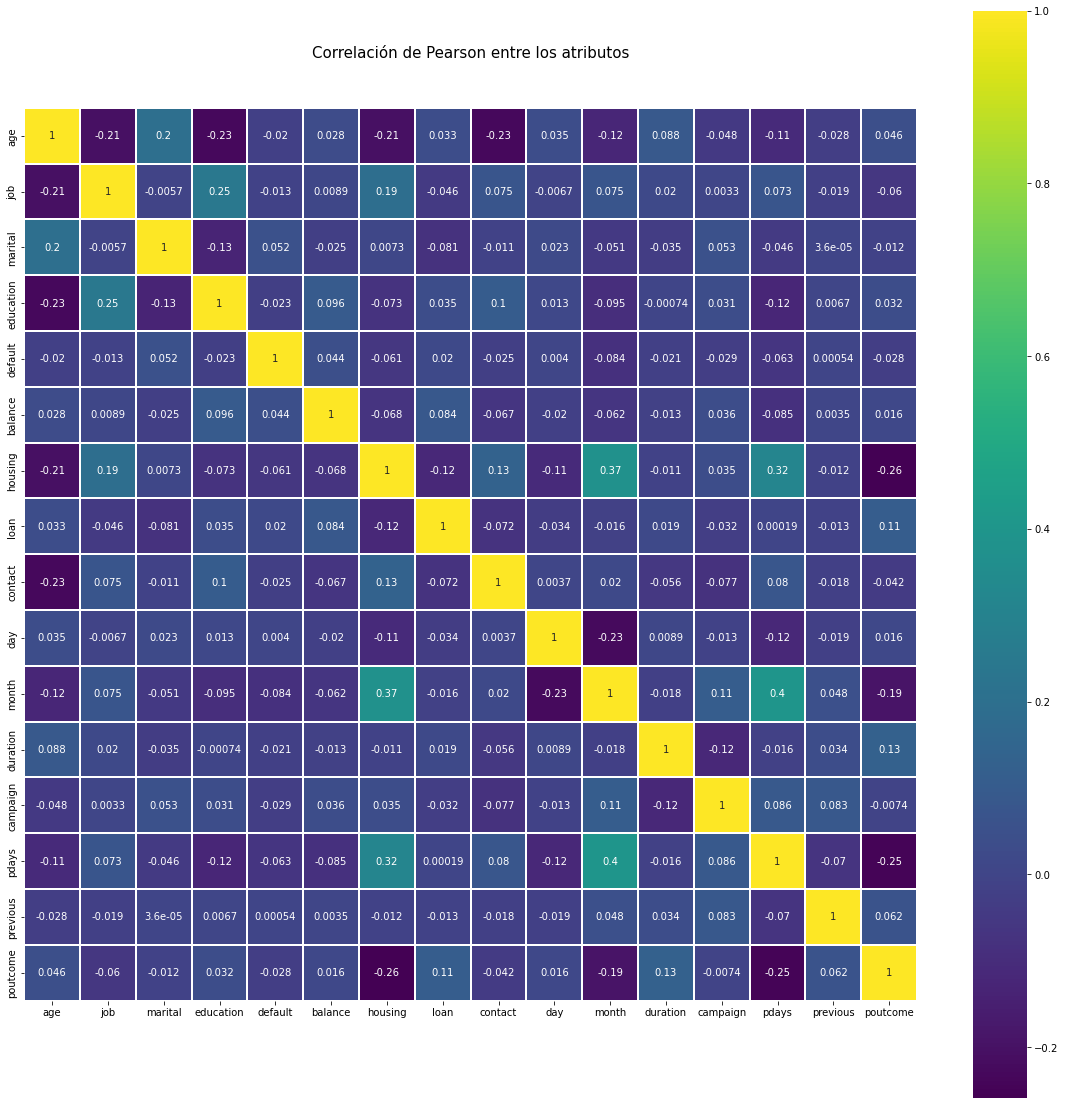

In [18]:
# df_freq = df_freq.drop("y", axis= 1)

plt.figure(figsize=(20,20))
plt.title('Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(df_freq.astype(float).corr(), linewidths=0.1,vmax=1.0, square=True, cmap='viridis', annot=True)

## (Latent Dirichlet Allocation) LDA

Se usa para encontrar una combinación lineal de características que caracteriza o separa dos o más clases o niveles de una variable categórica

In [64]:
x_data_enco = df_freq.iloc[:,0:-1]
y_data_enco = df_freq.iloc[:, -1]

lda = LDA(n_components= 1)
X_lda = lda.fit_transform(x_data_enco, y_data_enco)
X_lda.shape

(764, 1)

## (Analysis of variance) ANOVA

Consiste en el análisis de la varianza y es similar a LDA excepto que opera mediante una o más funciones independientes categóricas y una función dependiente continua.

In [39]:
vthreshold = VarianceThreshold()
X_vthreshold = vthreshold.fit_transform(x_data_enco) 

## Chi-cuadrado

Es un prueba estadística que evaluan la probabilidad de correlación entre las características utilizando su distribución de frecuencia. Para realizar este estudio el conjunto de datos no puede tener valores negativos por lo que vamos a pasar al escalado de los valores

### Escalado
Vamos a probar algunas formas de escalar los datos, entre ellos la normalización, escalado entre min y máximo y estandarizado.

In [14]:
def scale(x, type):
    if(type == "normalize"):
        return normalize(x)
    elif(type == "maxmin"):
        scaler = MinMaxScaler() 
        return scaler.fit_transform(x)
    elif (type == "standard"):
        ## media 0 y desviacion unitaria
        scaler = StandardScaler()
        return scaler.fit_transform(x)
    else:
        raise "error"

In [56]:
# Shift 1
x_scaled = normalize(x_data_enco) + 1
X_chicuadrado = SelectKBest(chi2, k=14).fit_transform(x_scaled, y_data_enco)
X_chicuadrado

array([[1.00664213, 1.01167405, 1.09178218, ..., 1.00020128, 1.0682328 ,
        1.        ],
       [1.01791849, 1.09061635, 1.11672615, ..., 1.00051196, 1.16894575,
        1.        ],
       [1.02313685, 1.11700634, 1.15072003, ..., 1.00132211, 1.11634528,
        1.        ],
       ...,
       [1.02039177, 1.07673744, 1.24470119, ..., 1.0021465 , 1.08210369,
        1.        ],
       [1.01570757, 1.08022081, 1.25580901, ..., 1.00224394, 1.11836777,
        1.00056098],
       [1.02607366, 1.01244425, 1.13510898, ..., 1.00118517, 1.14755323,
        1.00059258]])

In [145]:
def feature_selection(df, type):
    df_select = df.copy()
    x_data = df_select.iloc[:,0:-1] 
    y_data = df_select.iloc[:, -1] 
    names = df.columns.to_list()[:-1]
    print(y_data)

    if (type == "pearson"): 
        df = pd.DataFrame(x_data, columns = names).drop('month',axis=1)
        return df.to_numpy()
    elif(type == "chi2"):
        x_scaled = normalize(x_data) + 1
        return SelectKBest(chi2, k=14).fit_transform(x_scaled, y_data)
    elif (type == "LDA"):
        lda = LDA(n_components=1)
        return lda.fit_transform(x_data, y_data)
    else:
        raise "error"
    

## Principal Component Analysis (PCA)

Este método está dentro de lo que conocemos como métodos de envoltura, ya que utiliza un algoritmo de Machine Learning para la selección del subconjunto de categorías. Además también sirve para visualizar los datos. Para utilizar PCA hay que estandarizar previamente los datos.

### Visualización de datos usando PCA

Varianza explicada total ratio cuando transformamos 16 características a 14 características es de 93.03547153731465%


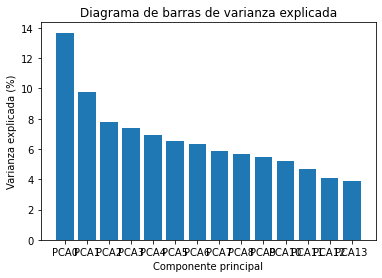

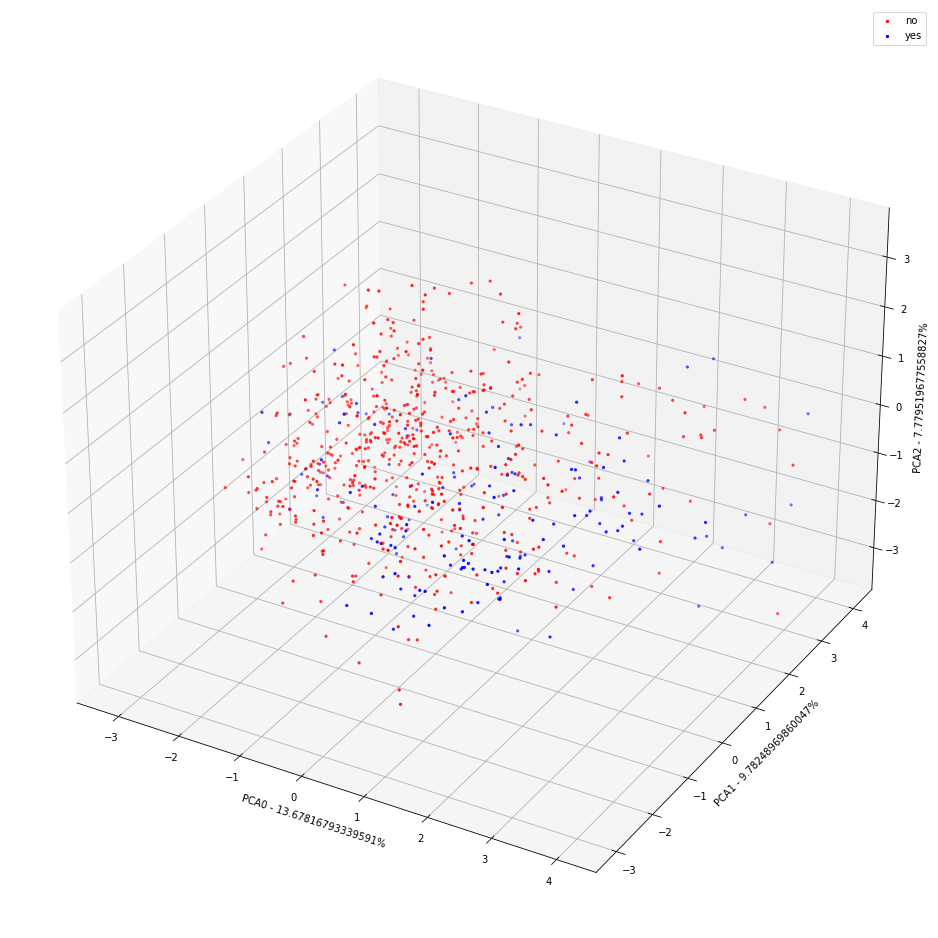

In [174]:
from operator import sub


def PCA_analysis(df, n_components, y_data = None):
    df_pca = df.copy()
    x_data = df_pca.iloc[:,0:-1] 
    if not y_data:
        y_data = df_pca.iloc[:, -1] 
    names = df.columns.to_list()[:-1]

    #Estandarizamos los datos
    x_data = StandardScaler().fit_transform(x_data)

    pca = PCA(n_components=n_components)
    prin_comp = pca.fit_transform(x_data)
    #Dibujamos un plot de barras para conocer la varianza de cada una de las componentes principales
    perc = pca.explained_variance_ratio_ * 100
    print("Varianza explicada total ratio cuando transformamos {} características a {} características es de {}%".format(len(names), len(perc), np.sum(perc)))
    labels = ["PCA" + str(num)  for num in range(n_components)]
    plt.bar(x = range(0, n_components), height = perc, tick_label =labels )
    plt.xlabel("Componente principal")
    plt.ylabel("Varianza explicada (%)")
    plt.title("Diagrama de barras de varianza explicada")
    plt.show()

    # Podríamos dibujar las componentes PCA1,PCA2 Y PCA3 en 3D
    figure = plt.figure(figsize=(17,17))
    subplot = figure.add_subplot(111, projection = "3d")
    
    class_name_1 = np.array(y_data.value_counts())[0]
    class_name_2 = np.array(y_data.value_counts())[1]    
    
    class_1_data = prin_comp[y_data == class_name_1]
    class_2_data = prin_comp[y_data == class_name_2] 

    subplot.scatter(class_1_data[:,0], class_1_data[:,1], class_1_data[:,2], c='r', marker=".", label = "no")
    subplot.scatter(class_2_data[:,0], class_2_data[:,1], class_2_data[:,2], c='b', marker=".", label = "yes")
    subplot.set_xlabel('{} - {}%'.format(labels[0], perc[0]))
    subplot.set_ylabel('{} - {}%'.format(labels[1], perc[1]))
    subplot.set_zlabel('{} - {}%'.format(labels[2], perc[2]))
    plt.legend()
    plt.show()
    # df_n = pd.DataFrame(data = prin_comp, columns=["PCA1", "PCA2", "PCA3"])

PCA_analysis(df_freq, 14)


Vamos a mostrar un gráfico de barras mostrando la varianza explicada a reducir las dimensiones del conjunto de datos. La varianza explicada indica cuánta información (varianza) puede atribuirse a cada uno de los componentes principales. Esto es importante, ya que aunque se puede convertir un espacio de 16 dimensiones (los atributos de nuestro dataset inicial) en un espacio de menor dimension, se pierde parte de la varianza (información) al hacerlo. Utilizando el atributo explained_variance_ratio_, se puede saber cuanta información se pierde, por ejemplo si se pasa de 16 características a 13 se perdería un 11% de informacion.

Se muestra tambíen la representación en 3 dimensiones en la que se puede separar que utilizando solo 3 dimensiones no es facil separar las clases.

# Aprendizaje de modelos predictivos (clasificación o regresión)

El objetivo de los modelos es el de clasificación por lo que utilizaremos varios modelos para realizar el aprendizaje y posteriormente la predicción. Existen modelos probabilísticos que predicen el nivel de probabilidad de pertenencia de una clase u otra. Además existen modelos de regresión que permiten estudiar si una variable binomial depende, o no, de otra u otras variables, y se pueden utilizar también para la clasificación.

Dividimos el conjunto de datos en entrenamiento y prueba para poder evaluar los modelos escalando los datos.

In [15]:
x_data = scale(df_freq.iloc[:,0:-1], "standard")
y_data = df_freq.iloc[:, -1]

X_names = df_freq.columns.to_list()[:-1]
y_names = df_freq.columns.to_list()[-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size= 0.75)

print("El conjunto de datos se ha dividio en {} entradas de train y {} entradas de test".format(len(x_train), len(x_test)))

El conjunto de datos se ha dividio en 573 entradas de train y 191 entradas de test


Vamos a comprobar el rendimiento utilizando un modelo de regresion logistica. Para pequeños datasets como este, el solver más adecuado es liblinear.

In [79]:
m_logistic =  LogisticRegression(solver= "liblinear", penalty="l2").fit(x_train, y_train)

print("Rendimientos sobre el conjunto de test:{}".format(m.score(x_test, y_test)))
print("Rendimientos sobre el conjunto de train:{}".format(m.score(x_train, y_train)))


Rendimientos sobre el conjunto de test:0.8586387434554974
Rendimientos sobre el conjunto de train:1.0


Se va a utilizar un recurso para comprobar cual seria el mejor rendimiento con diferentes párametros utilizando la clase *ParameterGrid*.

In [21]:
parameters_dict = {}
parameters_dict["solver"] = ["liblinear", "saga"]
parameters_dict["penalty"] = ["l1", "l2"]
parameters_dict["C"] = np.logspace(1.0,2.0, 20)
parameters_dict["max_iter"] = [100,500,1000]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = LogisticRegression(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)
    

/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jborrego/anaco

,accuracy,C,max_iter,penalty,solver
0,0.827225,10.000000,100,l1,liblinear
1,0.827225,10.000000,100,l1,saga
152,0.827225,42.813324,1000,l1,liblinear
153,0.827225,42.813324,1000,l1,saga
154,0.827225,42.813324,1000,l2,liblinear
155,0.827225,42.813324,1000,l2,saga
156,0.827225,48.329302,100,l1,liblinear
157,0.827225,48.329302,100,l1,saga
158,0.827225,48.329302,100,l2,liblinear
159,0.827225,48.329302,100,l2,saga


Como se observa no existen unos parámetros que hagan que el rendimiento del modelo sea mucho mejor que otro, si no que aún habiendo algunas variaciones en los parámetros el modelo tiene un rendimiento parecido.

El siguiente modelo que se utilizará será el de máquinas de vector soporte obteniendo la estimación de probabilidades

In [78]:
m_svm = svm.SVC(probability=True).fit(x_train, y_train)


print("Rendimientos sobre el conjunto de test:{}".format(m.score(x_test, y_test)))
print("Rendimientos sobre el conjunto de train:{}".format(m.score(x_train, y_train)))

Rendimientos sobre el conjunto de test:0.8586387434554974
Rendimientos sobre el conjunto de train:1.0


In [26]:
parameters_dict = {}
parameters_dict["kernel"] = ["linear", "poly", "rbf", "sigmoid"]
parameters_dict["probability"] = [True]
parameters_dict["C"] = np.logspace(1.0,2.0, 20)
parameters_dict["max_iter"] = [100,500,1000]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = svm.SVC(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)

/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-pac

,accuracy,C,kernel,max_iter,probability
161,0.842932,48.329302,poly,1000,True
232,0.842932,100.000000,poly,500,True
79,0.842932,20.691381,rbf,500,True
233,0.842932,100.000000,poly,1000,True
44,0.842932,14.384499,rbf,1000,True
113,0.837696,29.763514,poly,1000,True
125,0.837696,33.598183,poly,1000,True
173,0.837696,54.555948,poly,1000,True
209,0.837696,78.475997,poly,1000,True
208,0.837696,78.475997,poly,500,True


Vamos a probar otro modelo, que en este caso está basado en árboles de decisiones que se puede usar para clasificación como en este caso. Se va a utilizar el modelo de Random Forest, el parámetro mas importante en los modelos de assembling basados en árboles de decisión es el número de árboles que se usan (n_estimators), otros parámetros como max_depth es la máxima profundida del árbol o el mínimo numero de samples de una hoja (min_samples_leaf)

In [99]:
m_forest = RandomForestClassifier(n_estimators=20, criterion="gini")
m_forest.fit(x_train, y_train)


print("Rendimientos sobre el conjunto de test:{}".format(m.score(x_test, y_test)))
print("Rendimientos sobre el conjunto de train:{}".format(m.score(x_train, y_train)))

Rendimientos sobre el conjunto de test:0.8586387434554974
Rendimientos sobre el conjunto de train:1.0


In [70]:
parameters_dict = {}
parameters_dict["criterion"] = ["gini", "entropy"]
parameters_dict["n_estimators"] = [1,10,20,50,100,200,400]
parameters_dict["max_depth"] = [1,3,5,10,20]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = RandomForestClassifier(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)

,accuracy,criterion,max_depth,n_estimators
33,0.863874,gini,20,200
61,0.863874,entropy,10,200
69,0.858639,entropy,20,400
34,0.858639,gini,20,400
67,0.858639,entropy,20,100
62,0.858639,entropy,10,400
32,0.853403,gini,20,100
60,0.853403,entropy,10,100
50,0.848168,entropy,5,10
59,0.848168,entropy,10,50


## Validación cruzada

Se va a estudiar la validación cruzada para evaluar los resultados de los módelos, es decir, al dividir en conjunto de entrenamiento y test puede ser que las clases no estén balanceadas y que el conjunto de test y train no se parezcan demasiado, esto provocaría que los resultados de rendimiento que estamos obteniendo no serían fiables, para comprobar si esta división es correcta se utiliza la validación cruzada, lo que se hace es dividir el conjunto de datos en diferentes particiones y evaluar el modelo con utilizando todas esas particiones, si la desviación tipica de todas esas precisiones es pequeña y la media es parecida a la precisión inicial significará que la división inicial de los datos es buena.

Obtenemos una desviación típica pequeña por lo que significa que el conjunto de datos está equilibrado

In [36]:
cvs = cross_val_score(m, x_data, y_data, cv = 40)
mean, deviation = cvs.mean(), cvs.std()

print("La media del rendimiento de las 10 divisiones es: ", mean)
print("La desviacion del rendimiento de las 10 divisiones es: ", deviation)


La media del rendimiento de las 10 divisiones es:  0.8236184210526316
La desviacion del rendimiento de las 10 divisiones es:  0.07038056300985725


Comprobamos el rendimiento de los dos modelos utilizando el conjunto de datos que se obtuvo tras codificar los atributos categóricos utilizando one hot

Observamos que los rendimientos son similares

In [40]:

x_one_hot = scale(df_one_hot.iloc[:,0:-1], "standard")
y_one_hot = df_freq.iloc[:, -1]

X_names = df_freq.columns.to_list()[:-1]
y_names = df_freq.columns.to_list()[-1]

x_one_hot_train, x_one_hot_test, y_one_hot_train, y_one_hot_test = train_test_split(x_one_hot, y_one_hot, train_size= 0.75)

print("El conjunto de datos se ha dividio en {} entradas de train y {} entradas de test".format(len(x_one_hot_train), len(x_one_hot_test)))

El conjunto de datos se ha dividio en 573 entradas de train y 191 entradas de test


In [42]:
m =  LogisticRegression(solver= "liblinear", penalty="l2").fit(x_one_hot_train, y_one_hot_train)

print("Rendimientos sobre el conjunto de test utilizando regresion logistica:{}".format(m.score(x_one_hot_test, y_one_hot_test)))
print("Rendimientos sobre el conjunto de train utilizando regresion logistica:{}".format(m.score(x_one_hot_train, y_one_hot_train)))

m = svm.SVC(probability=True).fit(x_train, y_train)


print("Rendimientos sobre el conjunto de test utilizando svm:{}".format(m.score(x_test, y_test)))
print("Rendimientos sobre el conjunto de train utilizando svm:{}".format(m.score(x_train, y_train)))

Rendimientos sobre el conjunto de test utilizando regresion logistica:0.8481675392670157
Rendimientos sobre el conjunto de train utilizando regresion logistica:0.8307155322862129
Rendimientos sobre el conjunto de test utilizando svm:0.7539267015706806
Rendimientos sobre el conjunto de train utilizando svm:0.9144851657940664


## Métricas de evaluación del modelo

Se obtendrán algunas métricas de evaluación del modelo, usando la matriz de confusión podemos hacernos una idea de la fiabilidad del modelo. Se va a representar la matriz de confusión en un mapa de calor obteniendo los porcentajes de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos

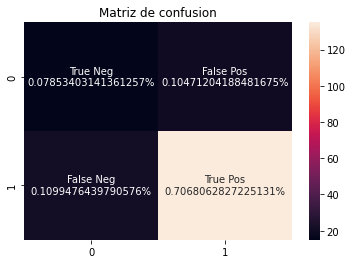

In [61]:
cf_matrix = confusion_matrix(y_test, m_.predict(x_test))
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = ["{}\n{}%".format(label[0],label[1])  for label in zip(labels, (cf_matrix/np.sum(cf_matrix)).flatten())]
sns.heatmap(cf_matrix, fmt="", annot = np.array(labels).reshape(2,2))

plt.title("Matriz de confusion")
plt.show()

Como se observa la mayor parte de las predicción son verdaderos positivos. Se va a calcular ahora la precisión, el recall y la métrica f1. En este caso concreto el significado de estas será:
* Precisión: Indica la calidad del modelo en tareas de clasificación, en este caso en el que las clases que queremos predecir es si el cliente va a contratar el servicio del banco o no, la precisión estaría respondiendo al porcentaje de los clientes que contactemos que estarían interesados.
    * P = TP/(TP+FP)
* Recall: Indicaría la cantidad de los que están interesados el modelo podría identificar
    * R = TP(TP+FN)
* F1: combina ambas métricas en un solo valor
    * F1 = 2* (P*R)/(P+R)


In [75]:
P = cf_matrix[1][1]/(cf_matrix[1][1] + cf_matrix[0][1])
R = cf_matrix[1][1]/(cf_matrix[1][1] + cf_matrix[1][0])
F1 = 2* (P*R)/(P +R)

print("El valor de precision es: ", P)
print("El valor de recall es: ", R)
print("El valor F1 es: ", F1)


El valor de precision es:  0.8709677419354839
El valor de recall es:  0.8653846153846154
El valor F1 es:  0.8681672025723471


Otra forma de evaluar los modelos es utilizando las curvas ROC y PR(precision- recall), nos permiten evaluar el rendimiento de clasificadores binarios y nos indican de manera visual la relación entre precisión y sensibilidad del modelo. Las metrícas de precision y recall están relacionadas de manera que si entrenamos el clasificador para aumentar la precisión, disminuirá el recall y viceversa. 

### Curva PR
La curva PR nos permite ver a partir de que recall tenemos una degradación de la preción y viceversa. Lo ideal sería que la curva se acercara lo máximo posible a un valor alto de recall y de precisión. 

En en título del gráfico vemos AP=0.94. Este valor es el Average precision y es una manera de calcular el área bajo la curva PR o PR AUC, o lo que es lo mismo, el resultado de integrar la curva. El Average Precision nos sirve para evaluar y comparar el rendimiento de modelos. Cuanto más se acerque su valor a 1, mejor será nuestro modelo.

### Curva ROC
La curva ROC (Receiver Operation Characteristic) relaciona el recall con el ratio de falsos positivos, es decir relaciona la sensibilidad de nuestro modelo con los fallos optimistas (clasificar los negativos como positivos). Tiene sentido ya que, generalmente, si aumentamos el recall, nuestro modelo tenderá a ser más optimista e introducirá mas falsos positivos en la clasificación.

En esta curva nos interesa que cuando aumente el recall (sensibilidad) no haga que nuestro modelo introduzca más falsos positivos. Comoo se observa en la grica de ROC análogamente al AP se puede calcular el ROC AUC que nos sirve para comparar modelos y que interesa que se acerque a 1. 

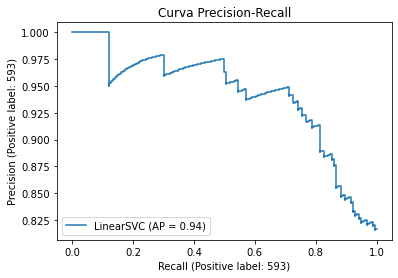

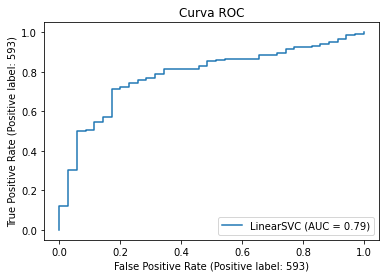

In [83]:
display = PrecisionRecallDisplay.from_estimator(
    m_logistic, x_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("Curva Precision-Recall")

display = RocCurveDisplay.from_estimator(
    m_logistic, x_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("Curva ROC")


Podríamos comparar las curvas PR y ROC para los tres modelos con el mismo set de datos, y comprobamos que aunque tienen rendimiento parecido, el modelo rendom forest es el que parece que mejor funciona.

Text(0.5, 1.0, 'Curva ROC')

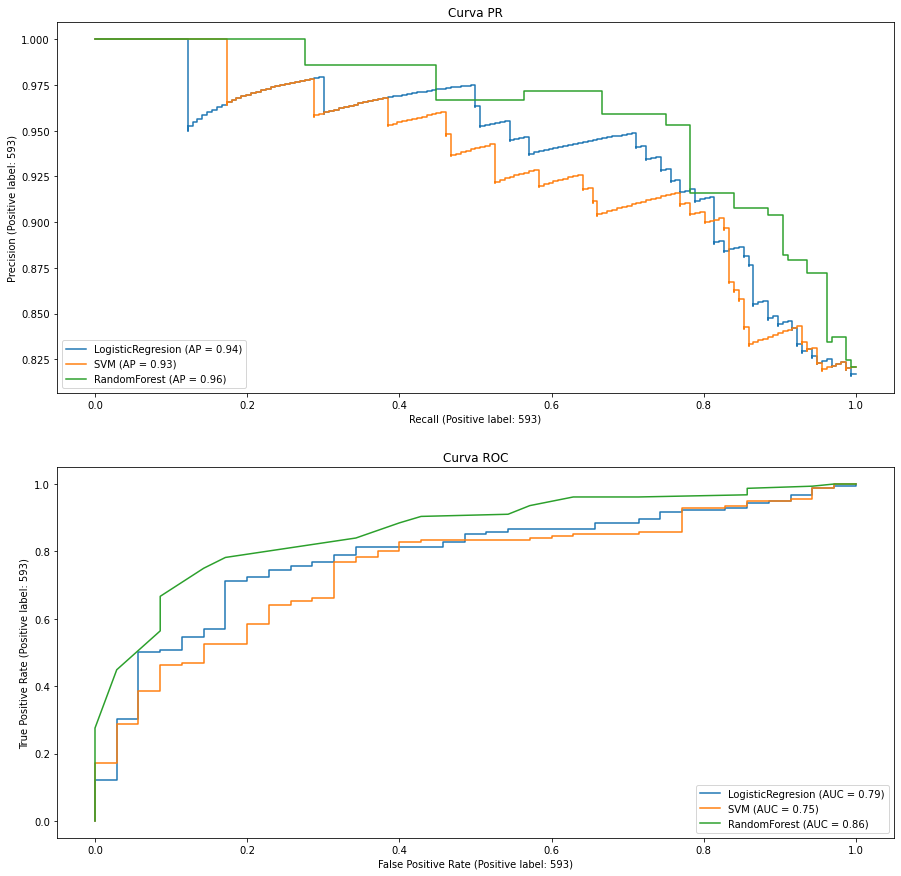

In [108]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

PrecisionRecallDisplay.from_estimator(
    m_logistic, x_test, y_test, name="LogisticRegresion", ax=axs[0])
RocCurveDisplay.from_estimator(
    m_logistic, x_test, y_test, name="LogisticRegresion", ax = axs[1]
)

PrecisionRecallDisplay.from_estimator(
    m_svm, x_test, y_test, name="SVM", ax=axs[0])
RocCurveDisplay.from_estimator(
    m_svm, x_test, y_test, name="SVM", ax = axs[1]
)
PrecisionRecallDisplay.from_estimator(
    m_forest, x_test, y_test, name="RandomForest", ax=axs[0])
RocCurveDisplay.from_estimator(
    m_forest, x_test, y_test, name="RandomForest", ax = axs[1]
)
axs[0].set_title("Curva PR")
axs[1].set_title("Curva ROC")


# 6.Evaluación final del modelo finalmente seleccionado y presentación de resultados.

Una vez exploradas las técnicas comentadas anterioremente se va a realizar una análisis completo para encontrar cuál es el modelo que con el que obtenemos mejore rendimiento y entender el por qué de esto-

In [223]:
# Cargamos dataset
df = pd.read_csv("bank_marketing_dataset.csv", delimiter=",")

x_data = df.iloc[:,0:-1]
y_data = df.iloc[:, -1]

X_names = df.columns.to_list()[:-1]
y_names = df.columns.to_list()[-1]


In [224]:
# sustituimos los valores desconocidos por la moda

df_sus = sustitution(df, "trend_sustitution")
df_sus

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,failure,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,cellular,3,jun,199.0,4,-1.0,0,failure,no
4,59,blue-collar,married,secondary,no,0,yes,no,cellular,5,may,226.0,1,-1.0,0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329.0,5,-1.0,0,failure,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,cellular,9,may,153.0,1,-1.0,0,failure,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151.0,11,-1.0,0,failure,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129.0,4,211.0,3,other,no


In [225]:
# Codificamos las variables ordinales + codificación por frecuencia de las demas variables categóricas

df_freq = encoding(df_sus, "frequency")
df_freq

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,128,2797,0.0,4445,1787,1962,3830,4220,19,80,79.0,1,-1.0,0,0.0,4000
1,33,417,2797,1.0,4445,4789,2559,691,4220,11,1398,220.0,1,339.0,4,0.0,4000
2,35,1007,1196,2.0,4445,1350,2559,3830,4220,16,293,185.0,1,330.0,1,0.0,4000
3,30,1007,2797,2.0,4445,1476,2559,691,4220,3,531,199.0,4,-1.0,0,0.0,4000
4,59,946,2797,1.0,4445,0,2559,3830,4220,5,1398,226.0,1,-1.0,0,0.0,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,417,2797,1.0,4445,-333,2559,3830,4220,30,706,329.0,5,-1.0,0,0.0,4000
4517,57,183,2797,2.0,76,-3313,2559,691,4220,9,1398,153.0,1,-1.0,0,0.0,4000
4518,57,768,2797,1.0,4445,295,1962,3830,4220,19,633,151.0,11,-1.0,0,0.0,4000
4519,28,946,2797,1.0,4445,1137,1962,3830,4220,6,222,129.0,4,211.0,3,1.0,4000


In [227]:
# Utilizamos chi2 para obtener las caracteristicas

x_freq = feature_selection(df_freq, "chi2")


0       4000
1       4000
2       4000
3       4000
4       4000
        ... 
4516    4000
4517    4000
4518    4000
4519    4000
4520    4000
Name: y, Length: 4521, dtype: int64


In [228]:
# Escalamos los datos

X = scale(x_freq, "standard")
X

array([[-0.98196618, -1.65383618,  0.7224773 , ..., -0.40290931,
        -0.31876065, -0.26118963],
       [-0.9261236 , -0.88605728,  0.50999098, ...,  2.68788314,
         1.84540354, -0.26118963],
       [-0.48885257,  1.03359241, -0.97249625, ...,  2.92903669,
         0.28053868, -0.26118963],
       ...,
       [ 1.29417899,  0.27463008,  0.77145842, ..., -0.40306736,
        -0.31876065, -0.26118963],
       [-1.12911955,  0.78352489,  0.7435562 , ...,  1.68357682,
         1.43896341,  2.32884476],
       [ 0.83162119, -1.44251987, -0.76854191, ...,  2.49683958,
         4.51770797,  2.7930733 ]])

Varianza explicada total ratio cuando transformamos 16 características a 10 características es de 75.48944342991479%


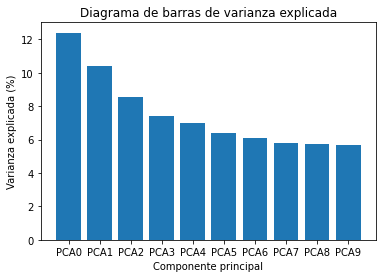

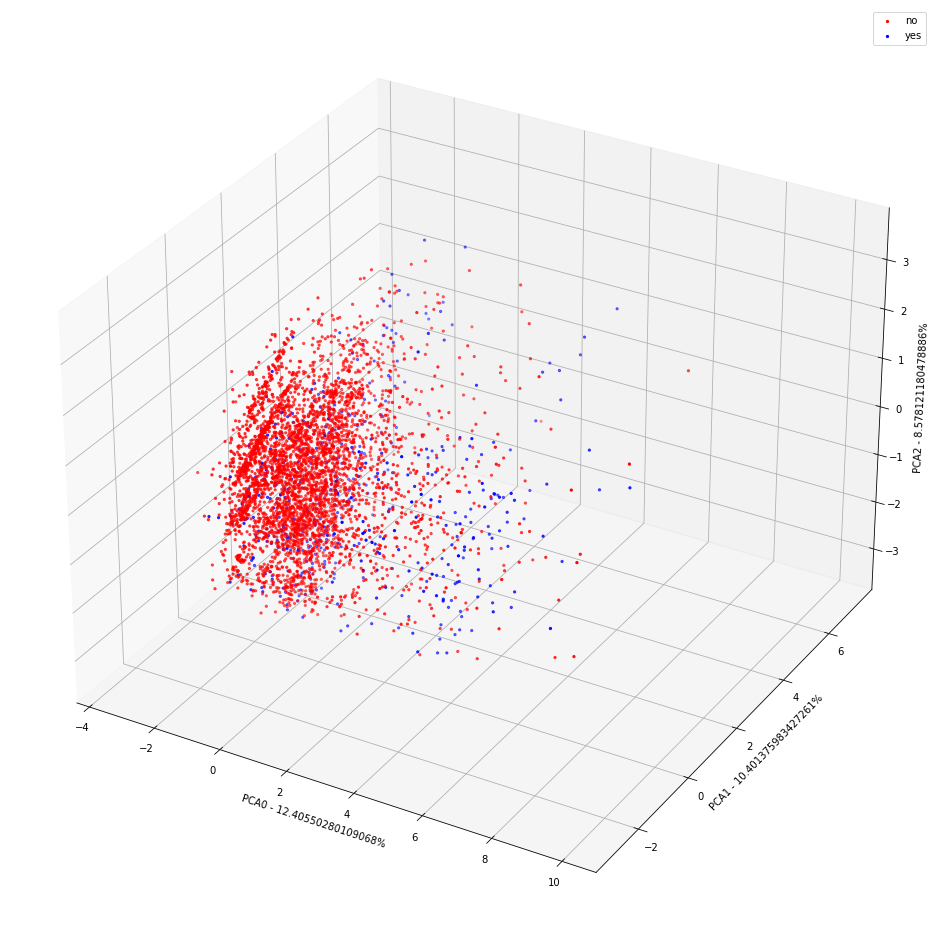

In [231]:
pca_data = PCA_analysis(df_freq, 10)

In [239]:
x_train, x_test, y_train, y_test = train_test_split(X, y_data, 
                                                    random_state=20,test_size=0.35)

Modelo de regresión: 
* Mejor accuracy: 0.905243

In [234]:
parameters_dict = {}
parameters_dict["solver"] = ["liblinear", "saga"]
parameters_dict["penalty"] = ["l1", "l2"]
parameters_dict["C"] = np.logspace(1.0,2.0, 20)
parameters_dict["max_iter"] = [100,500,1000]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = LogisticRegression(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)
    

,accuracy,C,max_iter,penalty,solver
0,0.905243,10.000000,100,l1,liblinear
1,0.905243,10.000000,100,l1,saga
152,0.905243,42.813324,1000,l1,liblinear
153,0.905243,42.813324,1000,l1,saga
154,0.905243,42.813324,1000,l2,liblinear
155,0.905243,42.813324,1000,l2,saga
156,0.905243,48.329302,100,l1,liblinear
157,0.905243,48.329302,100,l1,saga
158,0.905243,48.329302,100,l2,liblinear
159,0.905243,48.329302,100,l2,saga


Support Vector Machine
* Mejor Accuracy: 0.899558

In [235]:
parameters_dict = {}
parameters_dict["kernel"] = ["linear", "poly", "rbf", "sigmoid"]
parameters_dict["probability"] = [True]
parameters_dict["C"] = np.logspace(1.0,2.0, 20)
parameters_dict["max_iter"] = [100,500,1000]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = svm.SVC(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)

/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jborrego/anaconda3/envs/aa/lib/python3.9/site-pac

,accuracy,C,kernel,max_iter,probability
8,0.899558,10.000000,rbf,1000,True
56,0.897663,16.237767,rbf,1000,True
44,0.897031,14.384499,rbf,1000,True
92,0.897031,23.357215,rbf,1000,True
7,0.896399,10.000000,rbf,500,True
32,0.895768,12.742750,rbf,1000,True
20,0.895768,11.288379,rbf,1000,True
80,0.895768,20.691381,rbf,1000,True
68,0.891977,18.329807,rbf,1000,True
19,0.891346,11.288379,rbf,500,True


Random Forest
* Mejor Accuracy: 0.901453

In [237]:
parameters_dict = {}
parameters_dict["criterion"] = ["gini", "entropy"]
parameters_dict["n_estimators"] = [1,10,20,50,100,200,400]
parameters_dict["max_depth"] = [1,3,5,10,20]

grid= ParameterGrid(parameters_dict)

results = {"accuracy" : [], "params"  : []}

for p in grid:
    m = RandomForestClassifier(random_state=120, ** p)
    m.fit(x_train, y_train)
    results["accuracy"].append(m.score(x_test, y_test))
    results["params"].append(p)

results = pd.DataFrame(results)
results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
results = results.sort_values('accuracy', ascending=False)
results = results.drop(columns = 'params')
results.head(10)

,accuracy,criterion,max_depth,n_estimators
27,0.901453,gini,10,400
26,0.900821,gini,10,200
25,0.899558,gini,10,100
17,0.898926,gini,5,50
24,0.898926,gini,10,50
19,0.898926,gini,5,200
60,0.898294,entropy,10,100
20,0.898294,gini,5,400
18,0.898294,gini,5,100
62,0.897031,entropy,10,400


Tras probar con varios modelos y utilizando la técnica de búsqueda de parámetros y tras llevar a cabo el preprocesado de los datos se llega a la conclusión de que el modelo RandomForest es el que ofrece mejor rendimiento tras haber llevado a cabo un preprocesamiento de :
* Sustitución por moda de valores ausentes.
* Codificación por frecuencia
* Selección de caracteristicas utilizando la correlación de pearson.

Utilizando las curvas PR y ROC podemos observar como el modelo de random forest es algo mejor a los demás.

Los parámetros del modelo son:
* criterio: gini
* max_depth: 10
* n_stimators = 400